# Softmax Regression

This guide introduces softmax regression, which is the bread and butter of machine learning when trying to answer categorical classification problems. Building upon the skills we've learnt in [Linear Regression II](https://williampangbest1.github.io/machine_learning/linear_regressionII.html), we will now rely on some built-in functions from PyTorch, as well as wrap our functions using OOP in order to make the code more compact and user-friendly.

Here's a sketch of what we will be doing:

- **Loading the Fashion MNIST dataset**<br>
We will be reading in the Fashion MNIST dataset, which is a collection of 10 different clothing images. As the dataset is quite large (a collection of 70,000 images), we will be using a PyTorch function to read the images in batches.

- **Defining the model**<br>
The model relates the input and parameters to the output. We will be computing the linear model like before, but with an additional twist: we will also apply a technique that normalizes the outputs of the lienar model into a vector that follows a probability distribution whose total sums up to 1.

- **Defining the loss function**<br>
The loss function is an algorithim that tell us how well our predictions is doing. Here we will be applying the cross-entropy loss,  which is a measure of the difference between the "ground-truth" probability distribution and the  "prediction" probability distribution.

- **Training the model**<br>
This is the part where we make predictions, and iteratively make changes to our parameter predictions so that it gets closer and closer to the "ground-truth". To do so we:
    - Initialize parameters (slope $m$ and bias term $b$)
    - Repeat until done:
        - Compute the gradient (i.e., the derivative of the loss function w.r.t parameters) of each batch
        - Update our parameters

### Loading the Fashion MNIST dataset

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim 
import torchvision

import matplotlib.pyplot as plt
import numpy as np

class FashionMNIST:
    def __init__(self, batch_size, resize = (28, 28)):
        self.batch_size = batch_size
        
        trans = torchvision.transforms.Compose([torchvision.transforms.Resize(resize),
                                    torchvision.transforms.ToTensor()])
        
        self.train = torchvision.datasets.FashionMNIST(
            root="../data", train=True, transform=trans, download=True)
        
        self.val = torchvision.datasets.FashionMNIST(
            root="../data", train=False, transform=trans, download=True)
    
    def get_dataloader(self, train):
        data = self.train if train else self.val
        return torch.utils.data.DataLoader(data, self.batch_size, shuffle=train,
                                       num_workers= 4)

### Defining the model, loss function

In [8]:
class SoftmaxRegression(nn.Module):
    def __init__(self, num_inputs, num_outputs, lr, sigma=0.01):
        super().__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.lr = lr
        
        # Initialize parameters
        self.W = torch.normal(0, sigma, size=(num_inputs, num_outputs),
                              requires_grad=True)
        self.b = torch.zeros(num_outputs, requires_grad=True)

    def forward(self, X):
        linear = torch.matmul(X.reshape((-1, self.W.shape[0])), self.W) + self.b
        X_exp = torch.exp(linear)
        partition = X_exp.sum(1, keepdims = True)
        return X_exp/partition
        
    def loss(self, y_hat, y):
        return -torch.log(y_hat[range(len(y_hat)), y]).mean()
        
    def optimizer(self):
        return optim.SGD([self.W, self.b], self.lr) 

### Training the model

In [9]:
class Trainer:
    def __init__(self, max_epochs):
        self.max_epochs = max_epochs
        
    def prepare_data(self, data):
        self.num_train_batches = len(data.get_dataloader(train = True))
        self.num_val_batches = len(data.get_dataloader(train = False))
        
    def prepare_model(self, model):
        self.model = model
    
    def fit(self, model, data):
        self.prepare_data(data)
        self.prepare_model(model)
        self.optim = self.model.optimizer()
        
        for epoch in range(1, self.max_epochs + 1):
                self.fit_epoch()
        
    def fit_epoch(self):
        for batch_index, (X, y) in enumerate(data.get_dataloader(train = True)):
            y_hat = self.model(X)
            loss = self.model.loss(y_hat, y)
            self.optim.zero_grad() 
            loss.backward()
            self.optim.step()

In [10]:
data = FashionMNIST(batch_size = 64)
model = SoftmaxRegression(num_inputs = 784, num_outputs = 10, lr = 0.1)
trainer = Trainer(max_epochs = 10)
trainer.fit(model, data)

In [15]:
# Do not refresh as it resets
frame = iter(data.get_dataloader(train = False))

In [20]:
X, y = next(frame)
preds = model(X).argmax(axis=1)
print('Accuracy:', sum(preds == y)/len(y))

Accuracy: tensor(0.9062)


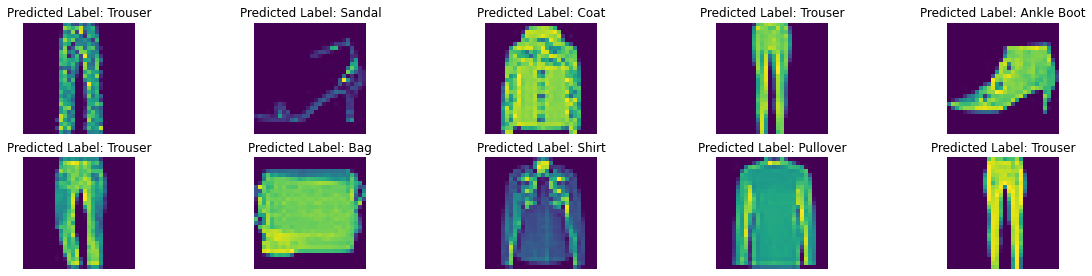

In [22]:
labels = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot']

fig = plt.figure(figsize=(20,7))
for i in range(0,10):
    ax = fig.add_subplot(3,5, i+1)
    no_channelX = X[:, 0, :, :]
    ax.imshow(no_channelX[i])
    ax.set_title('Predicted Label: {name}'.format(name = labels[y[i]]))
    #ax.set_title(labels[y[i]])
    plt.axis('off')